<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [264]:
%%capture
pip install pyswarms

In [265]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [266]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [267]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [268]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [269]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [270]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [271]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - math.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [272]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [273]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [274]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [275]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [276]:
# Defina o dicionário de tipos de dados
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario02.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario03.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario04.csv.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0


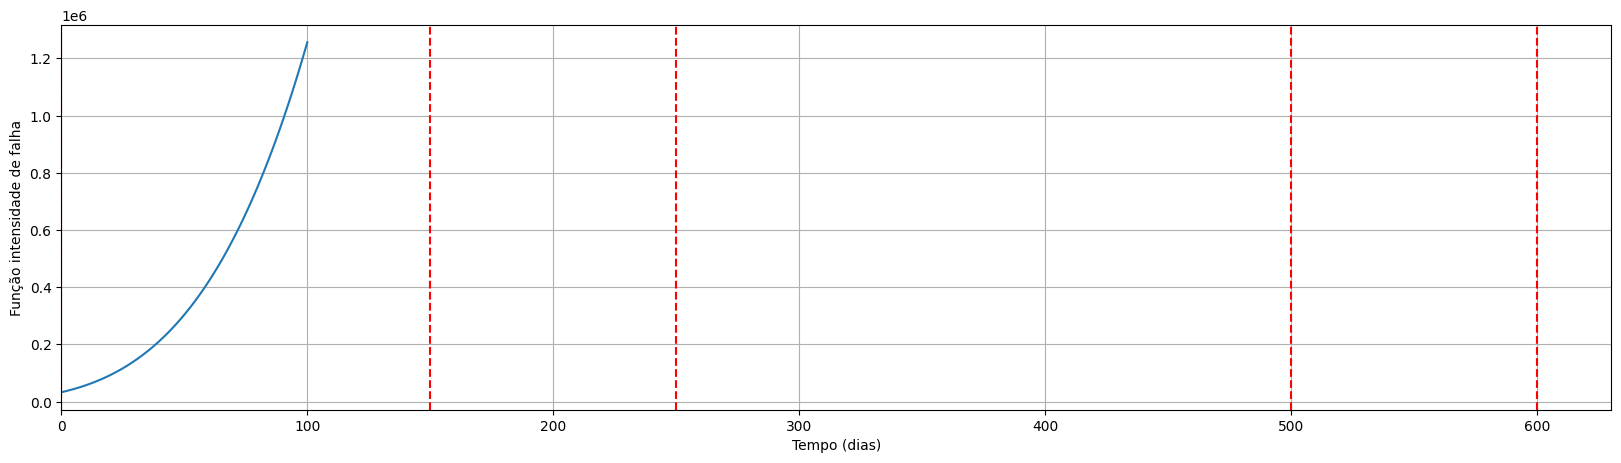

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [277]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [278]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [279]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-30 16:48:24,187 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=7.39e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 160, 242, 347, 397, 469, 482, 528, 703]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 33554432.0, 106699425.04025982, 139068850.0866814, 148929298.91664773, 848038119.5286126, 869465203.5345128, 1605054593.5419178, 3712894688.226019, 3371885158.9599237]
Custo =  177247780146.7899


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 21, 45, 258, 400, 474, 499, 544, 653, 677]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 

pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=5.33e+10


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 78, 112, 171, 211, 255, 280, 349, 363, 427, 576, 604, 644, 716]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 923895.7977600001, 2329332.7701330017, 3663741.482441404, 7041517.950170306, 44196744.44596345, 49447309.636182144, 93916978.42334354, 145246488.29836324, 572677763.0978981, 848494832.4853444, 867336818.5875118, 2300848003.864148, 2430645601.5786753, -1467093843.8944564]
Custo =  343879894054.89734


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 33, 71, 218, 266, 346, 365, 446, 478,

pyswarms.single.global_best:  50%|█████     |50/100, best_cost=5.33e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 5, 38, 74, 146, 295, 377, 415, 528, 573, 637, 669, 719]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1.0, 20313.564296998287, 119937.0789513355, 7042554.899236965, 70192570.66718917, 398535037.3133218, 629968819.0083323, 745348996.6113486, 907665425.6207936, 1275892407.2389708, 2622065252.4794173, 3061617656.04088, 2668181945.581585]
Custo =  300658677871.2585


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 72, 168, 305, 381, 410, 446, 530, 622, 672, 695]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.5

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=5.33e+10<ipython-input-278-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=4.68e+10

 [0, 1115771.00832, 20982749.70734493, 24516901.676957887, 28474376.097711656, 34092752.75023619, 97245916.46829028, 150789575.32501933, 156075247.4290596, 689855762.4283866, 881425606.9858881, 3713263536.9961863, 3329795365.51475]
Custo =  267202882342.4054


Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 45, 82, 232, 242, 303, 435, 559]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 59049.00000000001, 488424.315579239, 43692133.82961618, 43860855.65617654, 66392997.96664208, 167342501.18837348, 2566346578.953773, 2596694580.5495267]
Custo =  86155859752.55736


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 173, 227, 263, 286, 366, 419, 439, 520, 564, 604]
Severidade para cada subsist

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=4.68e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 81, 146, 212, 258, 278, 357, 363, 437, 529, 713]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 8696521.330004154, 11663489.04574307, 52316347.650818095, 56263583.93428892, 115313870.52389194, 115763176.74044241, 655137291.0176445, 2093546143.8315792, 2890559407.9764585, 2516990032.1121993]
Custo =  130560271959.91281


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 1, 82, 99, 147, 248, 353, 480, 646]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.776869

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=4.68e+10

Custo =  426498731563.9208


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 7, 78, 147, 231, 265, 353, 386, 438, 500, 521, 566, 612, 681, 698]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 5.378240000000001, 795077.2307372587, 3636607.534131181, 10580572.629279207, 44501110.24055581, 111946814.88841769, 136792749.9634838, 525322826.41907823, 555743082.2529165, 563312973.8190463, 591405576.9459505, 629706409.7179251, 3663709591.5695553, 3786418499.8848557, 3461477317.998822]
Custo =  267747053589.34836


Número de ciclos de manutenção: 11 5
Tempo

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.68e+10
2023-09-30 16:48:25,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23425371 6.348562   5.72574876 3.05349664 1.76713661 5.29004986
 3.99905101 2.46978363 2.47442042 0.56611283 4.52274711 1.47320522
 3.39511628 4.60855668 6.48777056 2.35263289 6.63204459 3.4731047
 1.77531371 1.48697045 3.48409321 0.37499795 4.4251366  4.40086642]
2023-09-30 16:48:25,583 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 50, 82, 242, 277, 329, 407, 537, 556, 600, 689, 706]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 100000.00000000001, 472732.86617442203, 80046884.01662463, 81686633.17888077, 105800343.3933742, 130581754.20170008, 2269651847.1906233, 2325757960.4229445, 2514679951.7980886, 3259134047.3495, 3387509400.435111, 3036796194.366996]
Custo =  177060207341.96686


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 56, 81, 165, 299, 326, 401, 547, 605, 683, 704]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,602 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23430823 6.35027841 5.72603332 3.0535477  1.76997857 5.29218225
 3.99837559 2.48038584 2.47446468 0.57432941 4.54473835 1.47300516
 3.0732007  4.6089584  6.48786441 2.34046942 4.15277019 5.3966763
 1.77526541 1.48666517 3.48427094 0.37237273 4.42707576 4.40054882]
2023-09-30 16:48:25,604 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 4, 59, 81, 114, 146, 303, 357, 373, 393, 446, 532, 542, 636, 680, 701]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.32768, 204326.65886688858, 221406.26023630163, 526414.9768618782, 723040.6835913111, 133496788.2873064, 309640662.3186253, 374871063.9492346, 474891266.5299357, 900608855.2329979, 1175523318.2969446, 1179282465.6028118, 4270991525.782684, 4577690162.970953, 4733297848.948087, 4398730414.947355]
Custo =  301575169887.6597


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23476011 6.35100024 5.72775812 3.0535926  1.77490305 5.29234492
 3.99882094 2.48291053 2.47447414 0.57365847 4.55508181 1.47144747
 3.1328508  4.60786759 6.48774166 2.34056145 1.89744081 5.98135901
 1.77510768 1.48644895 3.48490652 0.37115489 4.42584363 4.40017811]
2023-09-30 16:48:25,619 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 13, 52, 81, 144, 281, 358, 494, 519, 604, 652, 679, 697]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 79240.97967368786, 114486.16725981855, 2309126.5532745384, 46583791.41802126, 297358968.31142783, 446361986.9538337, 827227506.6581602, 3106287318.51226, 4902782136.4912615, 5081792401.14878, 5211281369.480598, 4889539836.405656]
Custo =  405314087769.18964


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23510762 6.3510312  5.72886692 3.05361065 1.77843725 5.29200872
 3.99927969 2.48313439 2.47448082 0.57126344 4.5627886  1.47019486
 3.26478004 4.6070521  6.48763372 2.34133329 5.86519893 5.94963967
 1.77497069 1.4862597  3.4852594  0.37115061 4.42465776 4.40002001]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 24, 44, 82, 143, 209, 294, 356, 390, 509, 683, 697]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 21789.159874471185, 101760.82556956401, 2108962.70790096, 4977317.24264982, 130778708.70058554, 171687701.85217246, 198452709.61214763, 1779630356.1360643, 3674725821.0732937, 3774524648.9964094, 3452783115.921467]
Custo =  150522216204.81265


2023-09-30 16:48:25,646 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,659 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23518739 6.35067373 5.72970299 3.05360366 1.77834036 5.29130212
 3.99962812 2.48193508 2.47447316 0.56861178 4.56329719 1.46995325
 3.40272738 4.60645902 6.48755668 2.34310522 1.76838107 5.2631801
 1.77485836 1.48628277 3.48540774 0.37133531 4.42371301 4.39992216]
2023-09-30 16:48:25,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 82, 118, 141, 163, 207, 354, 397, 616, 636, 701]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 1186367.49824, 3019011.997014414, 3108434.059121076, 3692184.8923652293, 19714373.326522473, 491008841.81758344, 528940281.3875889, 6845876369.960342, 6946536789.827043, 7049476659.321963, 7019684581.637749]
Custo =  161217153649.144


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2351827  6.35017119 5.72989049 3.05358902 1.77598708 5.29051542
 3.99992801 2.47857342 2.47446621 0.56563021 4.55357426 1.47034202
 3.52549391 4.60595109 6.48752315 2.34502222 3.86768021 4.35400553
 1.77483892 1.48632899 3.48532892 0.37248157 4.42303181 4.39994439]
2023-09-30 16:48:25,685 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 58, 82, 114, 140, 206, 328, 352, 365, 404, 567, 578, 656, 706]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 210034.16576, 496139.80728655506, 1566114.5836010333, 1677925.1081663657, 8729946.155869262, 292854776.611062, 304944168.37432396, 306044798.150761, 518894443.32350385, 849643981.7776977, 886665310.2093037, 3818942256.345698, 6395272951.224651, 6364346130.8113165]
Custo =  413365906938.0765


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23511956 6.34935708 5.72964447 3.0535507  1.77361101 5.2897957
 4.00008962 2.47390956 2.474458   0.56302526 4.54428539 1.47136516
 3.6311751  4.60568765 6.48755971 2.34710191 5.21532719 3.47940338
 1.77492732 1.48641331 3.48499524 0.37384224 4.42255142 4.4001859 ]
2023-09-30 16:48:25,706 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 33, 82, 110, 139, 174, 206, 349, 363, 418, 486, 557, 587, 714]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 12523.325760000002, 593100.4191669014, 1404055.1739848717, 1542041.830509118, 2947402.386824306, 14506351.495996037, 174112075.2985797, 181678830.9564316, 520969758.6114309, 665127349.654206, 917853353.7742914, 936337958.4697063, 7520345584.021782, 3704240452.288169]
Custo =  399542709392.45447


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,724 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23492423 6.34854557 5.72850055 3.05350597 1.77122329 5.28918746
 4.00001856 2.46958919 2.47444722 0.56147565 4.53172612 1.47234471
 3.72429321 4.60548393 6.48765324 2.34964748 6.08044207 2.69095114
 1.77500821 1.4866021  3.48452519 0.375181   4.42270703 4.40055464]
2023-09-30 16:48:25,725 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 81, 104, 138, 206, 345, 551, 596, 618]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1115771.00832, 1847711.36884312, 2041596.0676102624, 9495663.628603572, 409690887.8047616, 1707849262.9686267, 2882694936.202319, 3561536792.829372, 3045045030.738911]
Custo =  379999512517.374


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,743 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23455252 6.34781923 5.72744485 3.05346313 1.76824251 5.28864357
 3.99992693 2.46575244 2.47443435 0.56116583 4.5181586  1.47322983
 3.80704897 4.60551553 6.48777014 2.35226082 6.30968868 2.08377625
 1.77515311 1.48680409 3.48406161 0.37634314 4.42312984 4.40093239]
2023-09-30 16:48:25,745 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 96, 138, 207, 287, 341, 392, 492, 516, 547, 616, 649, 662]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1115771.00832, 1476082.6895727664, 1802960.1823860446, 9580786.642497651, 117021690.46873704, 145941047.56446007, 389408406.00106615, 1552941900.955973, 1561551772.4368403, 1650713880.6608043, 2006250494.1090734, 3233663964.742467, 3767162707.844897, 1871260973.3716636]
Custo =  542581918827.09534


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23421678 6.34730294 5.72624192 3.05343266 1.76526679 5.28822383
 3.99962618 2.46344995 2.47441993 0.56127772 4.50682101 1.47402301
 3.86207759 4.6056378  6.48787541 2.35469543 5.86121493 1.90815026
 1.77529299 1.48700838 3.48364606 0.37715892 4.42355622 4.4012693 ]
2023-09-30 16:48:25,757 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 19, 81, 139, 171, 208, 338, 369, 404, 507, 546, 642, 663]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 746792.9144735283, 5170487.043828848, 5479263.665480676, 19294157.986151546, 362001005.66342354, 381436799.3107303, 573318974.4302604, 1924749010.895795, 1944892435.6674218, 2093242558.274681, 2953664690.092316, 2739450988.9984426]
Custo =  275088307819.27966


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23392347 6.34718069 5.72509771 3.05340797 1.76292455 5.28797158
 3.99931369 2.46316445 2.47440706 0.56216899 4.49720463 1.47458374
 3.87591246 4.60581648 6.48794015 2.35668153 4.91505939 2.18346606
 1.77542145 1.48718857 3.4833367  0.37784147 4.42439374 4.40150615]
2023-09-30 16:48:25,790 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 4, 32, 81, 141, 162, 311, 336, 409, 487, 535, 546, 598, 610, 633, 664, 694]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 0.32768, 8700.245456174029, 273888.4695612765, 5135097.392895069, 5252392.844955312, 298055704.34658444, 299938839.6770803, 707368830.7745258, 1586276000.487748, 1611627352.7928267, 1820449979.545215, 3188756791.4798927, 3543773566.328623, 4324574741.9595995, 5590965006.704752, 5625556187.970836, 5597330167.916067]
Custo 

pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 49, 81, 142, 170, 304, 337, 411, 549, 593, 610, 693]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 90392.07968000001, 445065.2509680865, 5537395.275522538, 5769534.754100954, 241868734.5763102, 329015504.0297478, 351901016.01912636, 2831885473.2916393, 2864003694.3645945, 3364312203.2368994, 7249068193.508109, 7221064348.951167]
Custo =  400211555034.02466


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,926 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23367203 6.34725349 5.72407215 3.05340543 1.76128291 5.28791878
 3.99899735 2.46366921 2.47439678 0.56348241 4.48927725 1.47506369
 3.79533124 4.60621096 6.48796117 2.35826625 3.57249109 2.79558212
 1.77551175 1.48731458 3.48307815 0.37765392 4.4253416  4.40164582]
2023-09-30 16:48:25,929 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 45, 81, 144, 311, 338, 363, 406, 483, 554, 587]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 59049.00000000001, 456820.1160980552, 6037273.5913015725, 106220276.92512691, 178977276.54873586, 269096213.5669322, 507498262.21378684, 673881835.4684141, 727660777.8134053, 1546612339.3657856, 1906142257.0429077]
Custo =  271742681710.0215


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,947 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23359971 6.3473935  5.72348382 3.05340869 1.76136704 5.28793006
 3.99871485 2.46518248 2.47439359 0.5652092  4.49170597 1.47504967
 3.70088103 4.60723683 6.48797655 2.35943933 2.28092794 3.49943759
 1.77558673 1.48737414 3.48299526 0.37700169 4.42617726 4.40168378]
2023-09-30 16:48:25,948 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 1, 43, 81, 145, 285, 303, 340, 384, 401, 559, 581, 641]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.75, 0.75, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 0.00032, 45266.76746782294, 387177.5886094289, 6225107.659038203, 54883076.27002489, 86540505.06135131, 90097003.91283342, 97210544.64363265, 189818765.684349, 485019144.2865789, 497122741.27896124, 2575065638.671159, 1360756796.610805]
Custo =  298324493065.8701


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23369304 6.3477461  5.72352592 3.05342399 1.76242177 5.28847863
 3.99850649 2.46728357 2.47439552 0.56678064 4.50000674 1.47454038
 3.57203838 4.60824844 6.48793639 2.35919347 0.59378658 4.12880117
 1.77557907 1.4873181  3.48324966 0.37604596 4.42665123 4.40152506]
2023-09-30 16:48:25,962 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 43, 81, 146, 274, 313, 342, 366, 392, 482, 564, 577, 629]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 47042.70176, 467063.7835062074, 6571737.010280228, 40723839.476864174, 116549820.51009528, 198268273.76699632, 287832269.07652014, 415459540.13289654, 1382729051.7397628, 1456423297.2085917, 1763743791.8954659, 3442021746.9491463, 2597573577.008743]
Custo =  441821010650.90125


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,975 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23378428 6.34816999 5.72369413 3.0534572  1.76427732 5.28904316
 3.99835546 2.4699182  2.47440395 0.56801664 4.51327082 1.47370976
 3.41405537 4.6092401  6.48785695 2.35865939 6.32089291 4.65854721
 1.77556651 1.48722902 3.48358685 0.37498754 4.42669631 4.40119836]
2023-09-30 16:48:25,977 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:25,991 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23389384 6.34855944 5.72413503 3.0534899  1.76619494 5.28958801
 3.99837119 2.4722552  2.47441246 0.56893667 4.52708138 1.47287889
 3.27040733 4.60996576 6.48776424 2.3579587  4.56229175 5.07048873
 1.77553217 1.4871



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 146, 153, 344, 385, 482, 516, 569, 575, 608, 630]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 8696521.330004154, 8715851.979463425, 595636261.4016175, 779399781.8325667, 1819335231.9604065, 1898085605.9733722, 1934608801.8642795, 1954126835.5646164, 2897728032.2639318, 3631154161.875198, 2756383052.976075]
Custo =  463031762048.41797


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,023 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23401595 6.34891003 5.72465999 3.05352095 1.76793997 5.29013899
 3.99839803 2.47393076 2.47442035 0.56903712 4.53838973 1.47221287
 3.16893222 4.6106097  6.48768249 2.35616117 2.45307745 5.04489238
 1.77543949 1.48702359 3.48426424 0.37345416 4.42582039 4.40062947]
2023-09-30 16:48:26,025 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 33, 81, 145, 346, 501, 574, 652]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 12523.325760000002, 553299.9504464322, 6391230.020875206, 227804066.6055073, 2166636887.6598754, 3770413448.9494824, 6631033448.8103485, 5065486364.196657]
Custo =  409855402717.57245


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,039 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23401595 6.34891003 5.72465999 3.05352095 1.76793997 5.29013899
 3.99839803 2.47393076 2.47442035 0.56903712 4.53838973 1.47221287
 3.16893222 4.6106097  6.48768249 2.35616117 2.45307745 5.04489238
 1.77543949 1.48702359 3.48426424 0.37345416 4.42582039 4.40062947]
2023-09-30 16:48:26,041 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 0, 30, 81, 144, 159, 347, 480, 512, 574, 653, 717]
Severidade para cada subsistema: [0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.0, 7776.000000000001, 514773.70461447735, 6095227.179817994, 6158685.483641605, 599276234.5957544, 1996698986.3977864, 2454774482.2484627, 2502960591.5291443, 2613777086.4706035, 6090472180.643686, 2151674708.9433203]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,056 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23423285 6.34925116 5.72552504 3.05355027 1.76989279 5.29077271
 3.99849443 2.47439388 2.47443134 0.56721759 4.54850561 1.47163798
 3.1190267  4.6102155  6.48763747 2.35299416 6.51303722 4.01394144
 1.77525524 1.4868382  3.48468416 0.37287213 4.42483943 4.40033584]
2023-09-30 16:48:26,058 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 24, 81, 143, 156, 284, 347, 385, 516, 576, 601, 648]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 2548.0396800000003, 669579.6743161017, 1722367.1405741517, 1770229.1618024744, 174311563.1563738, 184296793.25335124, 189962874.675213, 2027091840.4361274, 2259631969.1943803, 2275701230.353878, 3992944263.9026213, 3826637296.7246275]
Custo =  240928769007.01593


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,071 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23432761 6.34915278 5.72592472 3.05354958 1.76995945 5.29089451
 3.99859298 2.47398964 2.47443212 0.56622219 4.54764419 1.47170506
 3.2104151  4.60968246 6.48765573 2.35172918 4.88887594 3.51729348
 1.77519983 1.48676509 3.48470568 0.3732554  4.42450616 4.40034075]
2023-09-30 16:48:26,074 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 7, 81, 91, 142, 172, 209, 283, 347, 581]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 5.378240000000001, 965631.9298409749, 990063.7886983793, 1578814.1984995587, 2658077.5251418566, 16743149.052956734, 110641561.68575467, 149692797.7071574, 5568188710.225563, 6090342932.8646]
Custo =  211842120723.3075


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 81, 94, 142, 169, 209, 346, 364, 500, 585, 619]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1115771.00832, 1406433.6238185512, 1904691.0109376865, 2779840.785505318, 17963990.040072728, 84715163.13512887, 94737620.23458344, 1776732275.419822, 3779416395.8224516, 4823521507.478968, 4277625514.77792]
Custo =  387486033133.93805


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,088 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23439526 6.3489373  5.72627236 3.05353466 1.76976818 5.29091991
 3.99873995 2.47259934 2.47443031 0.56532272 4.53984811 1.47180606
 3.34628052 4.60888458 6.48767811 2.35075165 2.92719781 3.06268704
 1.77515817 1.48674241 3.48468722 0.37408064 4.42422442 4.40050191]
2023-09-30 16:48:26,090 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 29, 32, 81, 96, 141, 208, 322, 344, 489, 566, 588, 612]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 6563.56768, 7495.8022115420345, 185940.62550952483, 236159.65539152923, 648392.746472223, 8123260.62573295, 253542490.4686763, 263571960.94028667, 1907135414.6168861, 3501569143.7431526, 3514235838.9096518, 4224893919.8406215, 3883195232.9602933]
Custo =  373760773331.3821


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23443307 6.34869835 5.72645802 3.05351397 1.76908037 5.29092603
 3.99892599 2.47070269 2.4744276  0.56459341 4.5295551  1.47219074
 3.47483372 4.60812727 6.48770075 2.35024129 0.71900988 2.71867261
 1.77515193 1.48677583 3.48463065 0.37482825 4.42400689 4.40070047]
2023-09-30 16:48:26,105 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,118 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23443221 6.34845556 5.72662238 3.05349129 1.76795961 5.29091889
 3.99910429 2.46885908 2.47442324 0.56402662 4.51969348 1.47255685
 3.56858404 4.60755418 6.48773926 2.35017174 5.07054517 2.57636137
 1.77518811 1.4868



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 22, 47, 81, 96, 141, 175, 208, 286, 307, 343, 502, 528, 562, 591, 616, 652]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1649.16224, 33170.87457028331, 146263.1054960176, 196482.135378022, 608715.2264587157, 1982661.7035305323, 14361340.472009983, 23830167.353118062, 29953321.556794092, 47526081.23586175, 640912225.2282162, 1064949655.633393, 1772242759.40241, 1884380986.1911619, 2643573248.16976, 4004159898.1950054, 2438612813.581314]
Custo =  5

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,136 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23439336 6.34824166 5.72673367 3.05347106 1.76691626 5.29089634
 3.99925618 2.46741838 2.4744188  0.56382622 4.51082167 1.47302466
 3.62833049 4.6071442  6.48778024 2.35054778 2.42936239 2.47969628
 1.77523342 1.48693599 3.48428633 0.37604036 4.42409546 4.40110279]
2023-09-30 16:48:26,138 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 13, 49, 81, 96, 141, 208, 342, 514, 558, 591, 625, 643]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 118.81376000000002, 57300.01583108998, 336482.46612066106, 386701.49600266543, 798934.5870833592, 8273802.466344086, 379410658.844652, 1119011579.2187688, 2000166435.812562, 2129312706.026457, 3214811252.8778076, 3868772323.026708, 2591503074.314379]
Custo =  516421536134.268


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,150 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23431957 6.3480736  5.72660441 3.05345435 1.76599205 5.29069494
 3.99937705 2.4668281  2.47441484 0.56389051 4.50546647 1.47346507
 3.67958486 4.60683246 6.48781639 2.35128047 0.04047803 2.4917996
 1.77528966 1.48700773 3.48410266 0.37648464 4.42437799 4.40121376]
2023-09-30 16:48:26,152 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 46, 81, 95, 142, 171, 208, 298, 341, 481, 556, 591]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 65908.15232000001, 452742.17971478554, 496798.434653669, 967478.8962945587, 1975314.4306739164, 15790208.751344787, 30835953.067943245, 52273510.93032774, 464065645.6885091, 1910760007.9434247, 2801793748.3718777, 3051787544.9788256]
Custo =  306261296657.3217


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 15, 37, 81, 94, 142, 175, 208, 341, 556, 589]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 243.00000000000003, 11039.787507615461, 213984.40369450088, 252415.73592617523, 750673.1230453105, 2066108.4813817726, 14444787.249861222, 378308325.9355405, 1831880712.3687105, 2662138267.020986, 2967015861.743191]
Custo =  251222048739.25354


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23423515 6.34803385 5.7263757  3.05344627 1.76544356 5.29043712
 3.99941876 2.4665448  2.47441219 0.56444682 4.50090309 1.4738188
 3.71829658 4.60674882 6.48784186 2.35209772 5.01899787 2.74549718
 1.77534531 1.48707086 3.483936   0.37655705 4.42482262 4.40122224]
2023-09-30 16:48:26,170 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23416172 6.34807289 5.72615159 3.05345112 1.76510536 5.29014681
 3.99938999 2.46630617 2.47441059 0.56512537 4.49718672 1.47405608
 3.66247725 4.60669725 6.48786181 2.35293757 2.78774196 3.09627376
 1.77538802 1.48711



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 3, 81, 92, 143, 150, 209, 322, 340, 380, 390, 557, 587, 616, 638]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.07776000000000001, 1049294.5476864588, 1209224.610600402, 1807199.9231017404, 1919052.76732843, 24207866.950228993, 57309904.76018663, 64986368.85562765, 235221428.42581764, 284463884.6551551, 621318230.7721949, 639802835.4676098, 1517119112.0785089, 2288720633.1199694, 2155044595.849029]
Custo =  327236486876.2922


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,199 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2341091  6.34816862 5.72587339 3.053459   1.76489239 5.28987829
 3.99933493 2.46611501 2.47441125 0.56586003 4.49414217 1.47422538
 3.60303618 4.60673266 6.48787812 2.35366727 0.67442554 3.45676997
 1.77542476 1.48713544 3.4837226  0.37570713 4.42557888 4.40112288]
2023-09-30 16:48:26,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 48, 81, 91, 143, 294, 322, 341, 393, 558, 585]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 446831.01811599935, 586530.39209797, 1217818.8034454847, 113061276.71807647, 174999241.04324874, 228712692.86248523, 275069114.90953475, 3445853560.7663927, 3461824275.848342, 3875780672.0995517]
Custo =  216462415633.75635


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23409134 6.34826417 5.72562174 3.05347537 1.76486369 5.28964913
 3.99927676 2.46663123 2.47441203 0.56658083 4.4966681  1.47417185
 3.48962251 4.60691771 6.48787042 2.3540172  6.47612629 3.78160455
 1.77543215 1.48712846 3.48367246 0.37512758 4.42585005 4.40104228]
2023-09-30 16:48:26,216 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 30, 81, 144, 293, 318, 342, 370, 396, 510, 559, 582]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 172.10368000000003, 3521.6181995988086, 297492.917757557, 5877946.392961074, 68256389.69754831, 121071929.89221635, 122966678.9267706, 126090358.42329508, 259054034.8975547, 615929165.5417557, 646413619.9848154, 728689792.5657252, 1223874706.3418162]
Custo =  171081769835.18127


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23408278 6.34837293 5.72542612 3.05349204 1.76545025 5.28947936
 3.99918287 2.46794204 2.47441357 0.56712399 4.50451354 1.47398665
 3.37761278 4.60733301 6.48784339 2.354184   4.70152881 4.01934193
 1.77542625 1.48707755 3.4836646  0.37459006 4.42595702 4.40096261]
2023-09-30 16:48:26,232 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 41, 81, 144, 286, 343, 397, 518, 561, 580]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 37073.98432, 479899.5826238746, 6060353.057827392, 57279735.25825298, 215083178.4168582, 485733789.6786367, 2210269934.8225217, 2235762322.020093, 2302045798.986093, 2851117056.707832]
Custo =  216116645685.02338


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 22, 39, 81, 144, 344, 374, 397, 484, 525, 563, 579]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1649.16224, 11745.652708323234, 118950.39905863572, 5699403.874262152, 221370139.52151296, 342536358.8978512, 461844872.267273, 1413810864.0761895, 1432606886.5295053, 1557714797.5995255, 1612685543.690591, 2188622255.303849]
Custo =  223801900011.56268


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,275 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23409203 6.34851738 5.72533335 3.05350749 1.76634508 5.28935068
 3.99907541 2.46919459 2.47441695 0.56746877 4.51334743 1.47362259
 3.28191891 4.60785399 6.48780558 2.3539337  2.4975983  4.21473522
 1.77541885 1.48700754 3.48377306 0.37414366 4.4258791  4.40086419]
2023-09-30 16:48:26,310 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23411438 6.34865351 5.72529853 3.05351818 1.767354   5.28930292
 3.99897158 2.47035437 2.47442067 0.56772919 4.52291031 1.47321498
 3.21830395 4.60846244 6.48776392 2.35356417 0.67961863 4.21104098
 1.77540557 1.4869



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 7, 37, 81, 144, 172, 345, 367, 396, 532, 564, 579, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 5.378240000000001, 16085.600660323187, 219030.21684720862, 5799483.692050725, 6040080.052698269, 526991941.0420085, 610243474.6455686, 757969882.3871219, 2912991562.4274883, 2930325982.2395654, 2981717542.3156266, 5364813601.401218, 3992364783.5608764]
Custo =  388839088287.5025


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23415312 6.34876194 5.72538317 3.05352353 1.76825086 5.28941954
 3.99888333 2.47132118 2.47442401 0.56779367 4.53148452 1.47284623
 3.20673257 4.60902449 6.48772769 2.35317007 6.26032271 4.0356084
 1.77539119 1.48688865 3.48407271 0.37401607 4.4256364  4.40070499]
2023-09-30 16:48:26,592 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 144, 169, 294, 328, 345, 370, 393, 536, 566, 579, 643, 719]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 8069775.919014688, 8253577.1603458095, 199658245.13160974, 202406040.32602435, 210042427.72846323, 225398235.92002344, 339933563.18282914, 2675128922.866231, 2691274791.861755, 2735568978.5708303, 4973965103.028654, 9118771861.611727, 5097371961.617691]
Custo =  605469667821.5485


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23419053 6.34880904 5.72547702 3.05352402 1.76874229 5.28961124
 3.99880452 2.47208977 2.47442629 0.56768486 4.53686773 1.47254204
 3.23460202 4.60944523 6.4876963  2.35267193 4.38418842 3.85644742
 1.7753658  1.4868504  3.48421273 0.37413084 4.42542375 4.40065609]
2023-09-30 16:48:26,629 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 81, 90, 144, 316, 346, 382, 539, 567, 580, 719]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1289876.5963373126, 2002842.8302991802, 186293494.7940187, 274774939.52630836, 279846238.79053885, 2905364007.469242, 3512590346.5700645, 3557188592.3640223, 10945227719.415367, 6923827819.421331]
Custo =  531972004097.707


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,652 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23422845 6.34884663 5.72564177 3.05352347 1.769162   5.28988161
 3.99876103 2.47257706 2.47442675 0.56747808 4.54040186 1.47231565
 3.26828338 4.60980999 6.48768841 2.35221976 2.32041695 3.60975029
 1.77533971 1.4868239  3.48433244 0.37447451 4.42518077 4.40066545]
2023-09-30 16:48:26,654 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 25, 50, 81, 91, 144, 158, 345, 567, 581, 619]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 3125.0000000000005, 43332.23306389285, 312706.2083148845, 337138.067172289, 1013383.9693236428, 1311104.261336824, 577875276.2402539, 1341479409.0695035, 1681371684.9602427, 2844191732.768408, 2298295740.06736]
Custo =  360718783937.4009


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23426545 6.34887637 5.72580482 3.05352082 1.76903879 5.29013914
 3.99872862 2.47281696 2.47442664 0.56693739 4.54185862 1.47235544
 3.31409688 4.6098938  6.48769786 2.35182751 6.89936573 3.36024172
 1.77531018 1.48683851 3.48441172 0.37479794 4.42495908 4.40072328]
2023-09-30 16:48:26,692 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 81, 92, 143, 153, 209, 345, 362, 565, 583, 602]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1344590.008927957, 1942565.321429295, 2121425.3495754595, 23261946.965721563, 413641696.5458024, 422860822.88528943, 4570918759.718178, 4634824389.099534, 5164010027.545588, 5107751375.103657]
Custo =  335278941396.7903


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23429739 6.34883263 5.72595047 3.05351733 1.76883381 5.29035
 3.99872402 2.47227092 2.47442512 0.5662254  4.54270185 1.47261821
 3.37235673 4.60958143 6.48771723 2.35150189 4.00844932 3.16820554
 1.77528391 1.48687198 3.48445554 0.37514431 4.42477483 4.40081251]
2023-09-30 16:48:26,727 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 7, 81, 93, 142, 209, 314, 344, 380, 490, 539, 564, 585]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 5.378240000000001, 965631.9298409749, 998940.1918484336, 1526039.1131232195, 9114839.387490097, 212627536.62838268, 226923404.2889189, 380833301.7987441, 1636965846.3859348, 1778735146.559848, 2311071887.6400423, 2387288371.341152, 2801244767.592362]
Custo =  294649702429.34247


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23431737 6.34878786 5.72606314 3.0535128  1.76857481 5.29046984
 3.99874521 2.47171633 2.47442358 0.56556662 4.53899504 1.47292826
 3.42603661 4.60928451 6.48773533 2.35131542 0.88212634 3.07756266
 1.77526062 1.48692162 3.48441479 0.37541458 4.42464897 4.40089453]
2023-09-30 16:48:26,758 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 52, 81, 93, 142, 208, 302, 344, 534, 563, 587]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 121665.29024000002, 444966.042160959, 478274.30416841776, 1005373.2254432035, 8276114.868207689, 163560226.5228703, 185060403.0177924, 1191777481.4560254, 1802391542.5070484, 1891440061.2851832, 2250969978.9623055]
Custo =  240086888777.59836


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 81, 93, 142, 175, 208, 343, 508, 527, 561, 588]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23433459 6.34872021 5.72616424 3.05350792 1.76793699 5.29047419
 3.99880765 2.47091006 2.4744215  0.5650912  4.53183316 1.47326526
 3.46638736 4.6089635  6.48775313 2.3512297  6.0062958  3.04240225
 1.77524324 1.48697875 3.48436838 0.37558431 4.42453815 4.40096438]
2023-09-30 16:48:26,793 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [0, 1115771.00832, 1374579.2927118326, 1901678.2139866184, 3217113.5723230806, 15595792.34080253, 150242873.04721135, 809856258.3201041, 1119789471.0007176, 1228755408.77268, 1330495641.7680974, 1662727979.8712919]
Custo =  225709821612.252


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 93, 141, 208, 325, 343, 486, 520, 560, 588, 645]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1374579.2927118326, 1864876.1574978544, 9339744.036758581, 271130234.43608785, 279074708.0908767, 441410126.73477465, 958461261.2787843, 1774085141.6395898, 1879906080.6284263, 3908534293.0145674, 2567911584.397292]
Custo =  434920428616.41895


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,821 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23434803 6.34861493 5.72620272 3.05350137 1.76734301 5.29043628
 3.99893504 2.46986989 2.47441948 0.56483399 4.52326391 1.47355675
 3.49565025 4.60862862 6.48776958 2.35153214 3.74317959 3.02675953
 1.77524064 1.48702872 3.48425622 0.37571151 4.42459419 4.40102159]
2023-09-30 16:48:26,823 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1<ipython-input-278-3f464f4b430c>:86: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 48, 81, 92, 142, 208, 285, 343, 514, 560, 588, 600]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 81537.26976000001, 446831.01811599935, 606761.0810299426, 1164009.5502752922, 8434751.193039779, 108953049.78432585, 141545225.502343, 2520499720.464776, 3453492267.356479, 3559313206.345316, 3891545544.44851, 3891545544.44851]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,849 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23434803 6.34861493 5.72620272 3.05350137 1.76734301 5.29043628
 3.99893504 2.46986989 2.47441948 0.56483399 4.52326391 1.47355675
 3.49565025 4.60862862 6.48776958 2.35153214 3.74317959 3.02675953
 1.77524064 1.48702872 3.48425622 0.37571151 4.42459419 4.40102159]
2023-09-30 16:48:26,851 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 92, 142, 209, 295, 342, 387, 486, 511, 560, 588, 610, 637]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1115771.00832, 1344590.008927957, 1901838.4781733067, 9490638.752540186, 138540191.66443002, 162839836.00113502, 170418779.2023568, 1267075257.9911828, 1321090766.962232, 1485169418.3471599, 1590990357.3359964, 2235175635.3979, 3171759411.3727727, 3041388005.8916674]
Custo =  360815234894.36237


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23430569 6.34845626 5.7260036  3.05349168 1.76642896 5.29016917
 3.99913946 2.46866183 2.47441641 0.56492557 4.50944542 1.47386392
 3.48285315 4.60812054 6.4877899  2.35229418 0.43560385 3.2587924
 1.77528888 1.48707413 3.48406668 0.37584676 4.42492471 4.40103405]
2023-09-30 16:48:26,879 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 81, 91, 142, 179, 209, 343, 377, 512, 561, 586, 619, 638]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1905133.0586793805, 3591656.1604862185, 15113224.410883285, 147727499.84935734, 171237468.55179656, 2006549718.4579878, 2171752789.5244884, 2264161257.550064, 3278472094.064385, 3946793949.24049, 3813117911.9695497]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23427245 6.34844243 5.72586155 3.05348999 1.76630945 5.29003303
 3.99919437 2.46857671 2.47441606 0.56525657 4.50427556 1.4738362
 3.4532302  4.60802728 6.48779163 2.35255111 0.1326403  3.40749104
 1.7753203  1.48707673 3.48401621 0.37564044 4.42509969 4.40100232]
2023-09-30 16:48:26,926 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  368992781881.2949


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 2, 81, 91, 142, 209, 314, 343, 368, 515, 563, 584, 627, 643]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 0.01024, 1071091.1219993, 1076054.0309920525, 1664804.440793232, 9253604.715160111, 212766301.9560527, 226354595.7761915, 228967365.23662475, 2276799252.274669, 2440280343.6322827, 2515984806.8889055, 3895903421.8903704, 4478347829.357613, 4328267838.157228]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,946 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23424079 6.34845026 5.72570608 3.05348987 1.76633873 5.28991147
 3.99920363 2.46883482 2.47441659 0.56575779 4.50216466 1.47370736
 3.41336045 4.60794782 6.48779003 2.3527908  6.51241163 3.56008918
 1.77534763 1.48706851 3.48397867 0.37527218 4.42526164 4.40094834]
2023-09-30 16:48:26,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  382303812070.7589


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 39, 81, 91, 143, 152, 209, 281, 344, 361, 520, 564, 583]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 28871.743680000003, 495117.9201925279, 500080.8291852804, 1131369.2405327952, 1286420.7830970325, 22808240.3997471, 30257345.512992606, 67272168.64391169, 76391912.52328727, 2383459930.837667, 2532281960.719007, 2599928653.547479, 3068091290.6017866]
Custo =  202552984217.56024


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:26,974 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23421239 6.34848504 5.72556826 3.05348987 1.76647319 5.28981567
 3.99917153 2.46910742 2.47441755 0.56629776 4.50358161 1.47357819
 3.37466902 4.60797219 6.48778561 2.35296448 5.25965768 3.67165553
 1.77536725 1.48704765 3.48395748 0.37489596 4.42540174 4.40088073]
2023-09-30 16:48:26,976 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 40, 81, 90, 143, 209, 319, 344, 486, 525, 564, 581, 645]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 243.00000000000003, 17149.10265724941, 188726.105002757, 209340.6950895554, 875399.7087963321, 8257458.727484545, 235870200.56155574, 247454174.0790132, 684039363.5138986, 1297448622.362317, 1427162847.6083553, 1486537169.1098096, 3753216330.43256, 2412593621.8152847]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23419851 6.34852503 5.72546988 3.05349149 1.76675775 5.28979226
 3.99914239 2.46935919 2.4744185  0.56676263 4.50875735 1.47341199
 3.34558488 4.60802347 6.48777951 2.35307169 3.8315651  3.73075164
 1.77538148 1.48701606 3.48396552 0.37457222 4.42551508 4.40081951]
2023-09-30 16:48:27,018 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  373976908297.83466


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 46, 81, 90, 143, 283, 303, 344, 529, 565, 580, 654]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 65908.15232000001, 452742.17971478554, 573534.1190711383, 1239593.1327779149, 85932486.0931484, 120983404.30138285, 237520981.03224012, 1166408757.341391, 1930106261.2697387, 1981850060.085276, 4736113243.769554, 3105364941.8760138]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,040 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23418636 6.34856723 5.72541751 3.05349318 1.76707773 5.28980539
 3.99910956 2.46964941 2.47441964 0.56701667 4.51375818 1.47323811
 3.32200382 4.60807459 6.48777336 2.35307069 2.25263732 3.73940194
 1.77539129 1.48698244 3.4840028  0.37439676 4.42552091 4.40077836]
2023-09-30 16:48:27,048 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  409366342318.43317


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 81, 90, 143, 293, 345, 532, 566, 580]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1115771.00832, 1289876.5963373126, 1955935.6100440891, 111076549.52278043, 259037807.42289215, 1224014306.1813297, 1951828400.384216, 1999989300.89095, 2549060558.612689]
Custo =  244315172863.17432


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23419035 6.34860422 5.72543476 3.05349473 1.76737698 5.28985956
 3.99907593 2.4699169  2.47442077 0.56705589 4.51939978 1.47307711
 3.31947487 4.60813955 6.48776775 2.35302894 0.70742781 3.73165858
 1.77538618 1.4869505  3.48404797 0.37435562 4.42548876 4.40075364]
2023-09-30 16:48:27,079 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,103 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23419566 6.34863421 5.72553079 3.05349642 1.76763154 5.28994169
 3.99904006 2.47014414 2.47442174 0.56685493 4.52504032 1.47295171
 3.32357275 4.60822709 6.48776328 2.35289401 6.04902082 3.71082429
 1.77536603 1.4869



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 309, 345, 363, 483, 533, 565, 579, 628, 632]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 161578690.3172434, 265714460.6651718, 275629605.20670116, 1567658377.3649945, 1706788091.516567, 1724236063.3724298, 1772068863.8517818, 3347045725.91455, 3484624307.2424374, 3370908511.5294356]
Custo =  368212553852.18225


2023-09-30 16:48:27,108 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 31, 81, 91, 143, 282, 323, 344, 368, 534, 565, 580, 621, 634]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 9161.32832, 576382.0644699151, 581344.9734626677, 1212633.3848101823, 83726329.52244064, 174050702.80621803, 235356232.40914807, 249718931.9031598, 2930245818.44244, 3031408196.2610326, 3083151995.07657, 4350936691.984521, 4799489601.317105, 4679084098.789154]
Custo =  392665274352.9316


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,122 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23421677 6.34865841 5.72565068 3.05349797 1.76784132 5.29002167
 3.99900917 2.4702811  2.4744224  0.56660842 4.52966011 1.47287661
 3.33656907 4.60839729 6.48775981 2.35271968 4.00272385 3.67336038
 1.77533312 1.48690862 3.4841316  0.37473417 4.42532873 4.40073679]
2023-09-30 16:48:27,123 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 37, 81, 91, 142, 291, 344, 373, 509, 533, 564, 582, 615]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 22190.06624, 512531.4740011885, 536963.332858593, 1125713.7426597723, 106612298.21633625, 255535744.29818842, 274290430.42879033, 2080395123.906029, 2141358685.6946263, 2241824240.536348, 2305298061.6078277, 3293451928.248706, 2864701998.4189043]
Custo =  341220590914.91406



2023-09-30 16:48:27,141 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23424465 6.34866279 5.72577633 3.05349905 1.76795718 5.29009443
 3.9989824  2.47026494 2.47442254 0.56637657 4.53355074 1.4728706
 3.36087424 4.60855733 6.48775897 2.3525536  1.80544606 3.5939265
 1.77530313 1.48689553 3.48415974 0.37501926 4.42521986 4.4007704 ]
2023-09-30 16:48:27,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,157 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23427225 6.34865033 5.72588794 3.05349979 1.76802839 5.29014925
 3.99897015 2.47019145 2.47442243 0.56615193 4.53570644 1.47296142
 3.3864943  4.60870134 6.48776022 2.35240903 6.29983837 3.49537767
 1.77527868 1.4869007  3.48416521 0.37527233 4.42511026 4.40081244]
2023-09-30 16:48:27,



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 54, 81, 91, 142, 344, 378, 531, 563, 583, 609, 636]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 146932.80768, 449631.00141716306, 589330.3753991337, 1178080.7852003132, 340960367.14484435, 483592951.17595315, 2893003612.324893, 2996323100.079593, 3067732829.2520895, 3821069442.452946, 4751749230.101497, 4624690962.917971]
Custo =  381748474872.4013


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 22, 81, 92, 142, 303, 344, 382, 529, 563, 585, 605, 658]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1649.16224, 699454.1853337351, 705484.2855657225, 1262732.7548110723, 142223606.53508458, 258761183.26594186, 264277172.33766252, 2542889818.73491, 2653374659.2994404, 2733449828.385909, 3301149682.553794, 5351759088.085094, 5153413413.751982]
Custo =  387089026957.40594


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23429381 6.34863263 5.72594839 3.0535004  1.76809119 5.29018897
 3.99896513 2.47008191 2.47442191 0.56593944 4.53397189 1.47310874
 3.41052506 4.60883017 6.48776177 2.35231013 3.41735114 3.40019407
 1.77525965 1.48690913 3.48414994 0.37545318 4.42501432 4.40085463]
2023-09-30 16:48:27,174 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,198 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23430596 6.34861174 5.72597399 3.05350084 1.7678799  5.29021103
 3.99897336 2.46998305 2.47442118 0.56577658 4.52996544 1.47326413
 3.4280327  4.60890442 6.48776494 2.3522948  1.08655805 3.3153181
 1.775256   1.48691



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 18, 41, 81, 92, 142, 209, 273, 309, 343, 385, 527, 562, 587, 601, 656]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 604.6617600000001, 17488.315874399985, 381976.44436953857, 388006.54460152594, 945255.0138468756, 8534055.288213754, 78902266.8558552, 90758437.39932242, 107158545.40271083, 113806156.64955443, 2280984254.5946445, 2394302294.797792, 2487331563.824229, 2876697222.028416, 4975602129.180728, 4783627769.058266]
Custo =  375307254417.34766


2023-09-30 16:48:27,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 38, 81, 91, 142, 209, 278, 310, 343, 387, 499, 524, 561, 588]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 335.54432, 12300.499991466088, 127977.11383481475, 152408.97269221922, 741159.3824933986, 8329959.656860277, 89862878.02512267, 100248105.4509247, 103304066.68979913, 110605066.32957359, 1486167142.7239692, 1545766048.8366654, 1566419841.3558514, 1668160074.3512688, 2000392412.4544632]
Custo =  194293505311.992


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2343124  6.34858588 5.72596414 3.05350022 1.76746917 5.29019786
 3.99899344 2.46985195 2.47442038 0.56571134 4.52554605 1.47338839
 3.44194596 4.60891643 6.48776827 2.35237488 6.01534719 3.26600507
 1.77525477 1.48692919 3.48409378 0.37555476 4.42491924 4.40092702]
2023-09-30 16:48:27,214 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 91, 142, 151, 209, 309, 343, 385, 483, 522, 561, 588, 600]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1905133.0586793805, 2056251.8411089464, 23960814.88804404, 45583575.19416773, 61983683.19755614, 68631294.44439974, 1127775932.6678689, 1223960946.312092, 1351025088.8588655, 1452765321.8542829, 1784997659.9574773, 1784997659.9574773]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,255 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2343124  6.34858588 5.72596414 3.05350022 1.76746917 5.29019786
 3.99899344 2.46985195 2.47442038 0.56571134 4.52554605 1.47338839
 3.44194596 4.60891643 6.48776827 2.35237488 6.01534719 3.26600507
 1.77525477 1.48692919 3.48409378 0.37555476 4.42491924 4.40092702]
2023-09-30 16:48:27,259 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 81, 91, 142, 209, 299, 301, 343, 381, 485, 521, 561, 588, 602, 656]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1905133.0586793805, 9493933.33304626, 152161337.14300832, 152647127.68032792, 173914552.15554506, 179381187.40738463, 1320402600.716707, 1407582936.3956668, 2229101803.0567365, 2330842036.0521536, 2722815350.06167, 4785063555.165418, 4593089195.042955]
Custo =  439808462660.59576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23430832 6.3485367  5.72593325 3.05349799 1.76676381 5.29012487
 3.99904703 2.4696725  2.47441916 0.56576242 4.51964601 1.4735272
 3.43774693 4.60881022 6.48777362 2.35258142 0.84525417 3.33647253
 1.77528742 1.48697195 3.48404471 0.37525538 4.42502381 4.40094255]
2023-09-30 16:48:27,313 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 39, 81, 91, 142, 209, 343, 377, 509, 521, 562, 587, 604]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 495117.9201925279, 500080.8291852804, 1088831.2389864598, 8677631.513353338, 384032593.07420707, 407542561.7766463, 2160276131.345545, 2187106183.3756104, 2211081191.872062, 2304110460.898499, 2784939509.845944, 2672153532.8327503]
Custo =  319721516610.0662


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,344 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23429978 6.34852293 5.72590732 3.05349676 1.7665951  5.29007573
 3.99906818 2.46964423 2.47441892 0.56593891 4.51857948 1.47353258
 3.42366916 4.60871265 6.48777478 2.35268677 5.03765465 3.3863042
 1.77530581 1.48699055 3.48403589 0.37509946 4.4250892  4.40092622]
2023-09-30 16:48:27,345 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 37, 81, 91, 143, 209, 296, 343, 374, 492, 521, 562, 586, 607]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 22190.06624, 512531.4740011885, 536963.332858593, 1168251.7442061077, 8550310.762894321, 140909668.27115571, 165473109.86552268, 185939134.9441561, 1554194774.0640569, 1622716825.3128872, 1758124140.7405462, 1846577917.4316335, 2450014411.5299845, 2251920958.8452606]
Custo =  323291651826.23145


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23428723 6.34851484 5.72587364 3.05349563 1.76657242 5.29002977
 3.99908429 2.46963875 2.47441893 0.56613021 4.51800414 1.4734774
 3.40776585 4.60859007 6.4877753  2.35277292 1.92768309 3.44959231
 1.77532377 1.48700605 3.48403864 0.37494125 4.42515481 4.40090087]
2023-09-30 16:48:27,607 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23427061 6.34852014 5.72582546 3.05349478 1.76663679 5.28999225
 3.99909589 2.46966075 2.47441918 0.56630054 4.51852888 1.47342243
 3.39247612 4.60847776 6.48777479 2.35284099 6.35140989 3.50871269
 1.77533988 1.48701



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 81, 91, 143, 173, 209, 344, 370, 522, 563, 584, 611]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 763232.8148174301, 902932.1887994007, 1534220.6001469153, 2636204.0820200806, 16355256.191681575, 399165214.99632525, 415216090.0452793, 2651269620.33871, 2787609867.6064806, 2863314330.8631034, 3655256165.548745, 3342424569.2418365]
Custo =  333282709204.52576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,720 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2342515  6.34852778 5.72576174 3.05349413 1.76672609 5.28996098
 3.99909682 2.46968716 2.47441947 0.5664288  4.52003937 1.47336222
 3.37930372 4.60839517 6.48777339 2.35289555 3.41495826 3.55828752
 1.77535236 1.48701218 3.48406595 0.37470529 4.42524104 4.40083842]
2023-09-30 16:48:27,729 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 81, 91, 143, 154, 271, 344, 367, 523, 563, 582, 615]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 90392.07968000001, 445065.2509680865, 450028.159960839, 1081316.5713083537, 1285555.8060696886, 130968969.28951685, 176970748.63835225, 179279444.56964514, 2493452308.410583, 2626022612.216853, 2693212584.311412, 3681366450.95229, 3252616521.1224885]
Custo =  328381902513.7012


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,760 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23423489 6.34854229 5.72570128 3.05349419 1.76692422 5.28993646
 3.99909653 2.46972557 2.47442001 0.5664624  4.52180836 1.47330262
 3.36947244 4.60836409 6.4877719  2.35288283 0.1719762  3.58986826
 1.77535525 1.48700097 3.48408186 0.37465131 4.42525275 4.40081267]
2023-09-30 16:48:27,766 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 19, 36, 81, 91, 143, 344, 365, 490, 524, 564, 581, 619, 645]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 792.3516800000001, 8125.044689962008, 222477.8627533338, 246909.72161073826, 878198.1329582529, 336451405.22736573, 414303031.697999, 1839783184.9377072, 1923376489.4341166, 2762772385.193307, 2822146706.6947613, 3984966754.5029263, 4934198099.0478, 4777607722.640155]
Custo =  457302971766.3399


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,826 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23422386 6.34855579 5.72564999 3.05349484 1.7671255  5.2899329
 3.99909472 2.46977193 2.47442054 0.56639924 4.52348037 1.47323039
 3.36736169 4.60838541 6.48777047 2.35281292 5.00328122 3.59560784
 1.77534688 1.48698471 3.4840983  0.37466496 4.42524393 4.40080456]
2023-09-30 16:48:27,834 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 36, 81, 91, 143, 344, 365, 524, 564, 581, 622]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 19349.176320000002, 522008.7482472706, 661708.1222292412, 1292996.5335767558, 336866203.6279842, 414717830.0986175, 2792901763.3679504, 2926384855.385078, 2985759176.8865323, 4261800960.4176216, 3627210893.031054]
Custo =  348677385216.747


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 298, 344, 366, 498, 525, 564, 581, 623, 655]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 125230751.96118893, 255301298.11478138, 337641845.30484015, 1943844632.9078703, 2009129147.4883182, 2828287702.683491, 2887662024.1849456, 4202219723.262705, 5438470638.529045, 5249687981.818948]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,874 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23421846 6.34856939 5.72562432 3.05349569 1.76730866 5.2899551
 3.99908791 2.46981562 2.47442099 0.56629447 4.52488748 1.47315908
 3.37367575 4.60844875 6.48776919 2.35271023 2.72495462 3.57480554
 1.7753343  1.48696591 3.48411228 0.37468546 4.42522082 4.40081171]
2023-09-30 16:48:27,876 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  479435161979.9091


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 81, 91, 143, 151, 344, 367, 488, 525, 564, 581, 623]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 797091.0968086133, 936790.4707905839, 1568078.8821380986, 1700818.596160399, 596974682.8260881, 610526272.3566871, 1968126138.2289019, 2060750492.9128869, 2083392315.7011673, 2142766637.2026217, 3457324336.280381, 2793006600.007465]
Custo =  326828942994.4042


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,918 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23421936 6.34858146 5.72563639 3.05349659 1.76746259 5.28998969
 3.99907794 2.46984716 2.47442125 0.56619246 4.52612159 1.47310552
 3.38416701 4.60852608 6.48776811 2.35259526 1.12049761 3.55482215
 1.77532137 1.48694983 3.48412232 0.37478152 4.42519182 4.40082273]
2023-09-30 16:48:27,920 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 171, 344, 369, 502, 525, 564, 581, 622, 656]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 2907688.351093604, 518258139.8581115, 520896697.9994032, 2191888794.7251487, 2246767310.159541, 3065925865.3547144, 3125300186.8561687, 4401341970.387259, 5720664817.919046, 5528690457.796584]
Custo =  463863808771.5826


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,950 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23422485 6.34859069 5.72566468 3.05349742 1.76754684 5.29002297
 3.99906134 2.46987484 2.47442141 0.56609437 4.52666173 1.47306839
 3.39564726 4.60859982 6.48776744 2.35249247 6.22971692 3.5253799
 1.77530913 1.48693757 3.48412317 0.37490816 4.42515334 4.4008362 ]
2023-09-30 16:48:27,955 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:27,987 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23423559 6.34859649 5.72569872 3.05349794 1.76753779 5.29005763
 3.99904563 2.46989033 2.47442136 0.56601068 4.52633522 1.47306252
 3.40593423 4.60866584 6.48776749 2.35243327 3.8367324  3.49686407
 1.77529912 1.48693



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 1, 81, 91, 142, 151, 209, 294, 344, 371, 525, 564, 582, 620]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 1093248.4697320159, 1117680.3285894203, 1706430.7383905998, 1857549.5208201658, 23762112.56775526, 149563504.02569097, 176492948.80433384, 193421771.4184162, 2511893396.6749835, 2641607621.9210215, 2705081442.9925013, 3875496339.296394, 3300116387.9697943]
Custo =  338177752272.6764


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,018 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23425041 6.34859234 5.72573812 3.05349825 1.76751956 5.29008875
 3.99903227 2.46987405 2.47442106 0.56594148 4.52497313 1.47307809
 3.41238841 4.60869316 6.48776772 2.35242662 1.42782663 3.46579166
 1.77529084 1.48693349 3.48411252 0.37513628 4.42508478 4.40086221]
2023-09-30 16:48:28,022 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 58, 81, 91, 142, 156, 209, 344, 373, 488, 524, 563, 583, 617]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 210034.16576, 471911.8254290571, 496343.6842864616, 1085094.094087641, 1368659.8725689782, 21373332.15884986, 157182353.53180736, 175937039.66240928, 1466837223.1274025, 1555977065.2353392, 2369289751.631625, 2440699480.8041215, 3471273733.117058, 2984107225.283509]
Custo =  396692987410.479


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 5, 81, 91, 142, 172, 209, 270, 344, 374, 523, 563, 583, 614]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1.0, 1006766.596888108, 1011729.5058808605, 1600479.91568204, 2679743.2423243374, 16764814.770139214, 21316997.676500306, 68282690.93569615, 87986210.25412959, 2295601155.1704717, 2428171458.976742, 2499581188.149238, 3423474525.1424026, 3023817414.2983475]
Custo =  327435688310.9124



2023-09-30 16:48:28,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23426421 6.34858693 5.72577568 3.05349832 1.76748986 5.2901058
 3.99902553 2.46985116 2.47442077 0.56589339 4.52331493 1.47312981
 3.41601113 4.60871698 6.48776822 2.35248129 6.66587814 3.43797822
 1.77528814 1.48694493 3.48409911 0.37521228 4.42506086 4.4008751 ]
2023-09-30 16:48:28,059 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23427624 6.348579   5.72580628 3.05349818 1.76741636 5.29011807
 3.99902516 2.46981605 2.47442047 0.56590959 4.52172032 1.47317941
 3.41640702 4.60869363 6.48776896 2.35253431 4.37548913 3.42079718
 1.77528896 1.48696084 3.48408589 0.37526004 4.42505268 4.40088509]
2023-09-30 16:48:28



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 35, 81, 91, 142, 209, 344, 375, 523, 562, 584, 611]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 16807.0, 531974.1351721042, 536937.0441648568, 1125687.4539660362, 8714487.728332914, 391524446.5329766, 412201354.74621665, 2604697298.9219003, 2732640233.922665, 2812177904.0402765, 3604119738.7259183, 3291288142.4190097]
Custo =  332480503341.96655


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,112 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23428667 6.34856781 5.7258224  3.05349802 1.76730443 5.29011039
 3.99903142 2.46977976 2.47442018 0.56596894 4.52029767 1.47322969
 3.4108676  4.60866818 6.48776997 2.35258505 2.08050007 3.40929405
 1.77529524 1.48697519 3.48407518 0.37526979 4.42505412 4.40089097]
2023-09-30 16:48:28,118 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 2, 81, 91, 142, 150, 209, 344, 376, 523, 562, 585, 609, 659]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 1071091.1219993, 1210790.4959812707, 1799540.90578245, 1928880.2849936606, 24217694.467894223, 160026715.84085172, 181702042.22614428, 2359103720.93025, 2487046655.931015, 2571003572.278658, 3267748738.5653315, 5218558250.724091, 5017032523.042862]
Custo =  381289750889.15076


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 91, 142, 160, 209, 282, 344, 376, 485, 522, 562, 585, 608]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1905133.0586793805, 2327711.0952716535, 20834314.903182846, 28605735.481511388, 64783797.710574195, 68800128.95802858, 1263455213.0313365, 1354049398.198141, 2181495185.9834714, 2265452102.3311143, 2929420909.786148, 2702750979.5707016]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,144 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23428957 6.3485574  5.72582088 3.05349782 1.76717084 5.29009223
 3.99904047 2.46974742 2.47441994 0.5660486  4.51966628 1.47327215
 3.40257638 4.60862925 6.48777092 2.35264299 6.56770064 3.40825401
 1.7753054  1.48698758 3.4840662  0.37523234 4.42507121 4.40089543]
2023-09-30 16:48:28,151 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  384836215472.6299


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 31, 81, 91, 142, 209, 344, 375, 522, 562, 585, 607]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 9161.32832, 576382.0644699151, 581344.9734626677, 1170095.383263847, 8758895.657630727, 391568854.46227443, 412245762.67551446, 2573118179.2505064, 2704780397.75976, 2788737314.107403, 3420274936.5354133, 3222181483.850689]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23428429 6.34854867 5.72581371 3.05349759 1.7670501  5.29006485
 3.99904975 2.46972507 2.47441978 0.56612605 4.51919274 1.47330311
 3.39481206 4.60858627 6.48777178 2.35269398 3.61671019 3.41644095
 1.77531514 1.48699789 3.48406382 0.37517727 4.42509118 4.40089524]
2023-09-30 16:48:28,182 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  329146245695.1557


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 209, 276, 344, 374, 495, 523, 562, 585, 607, 635]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 9329730.078913929, 86257796.0422613, 127621641.52720457, 147325160.845638, 1584649377.62391, 1651575878.3692126, 2459074075.3637037, 2543030991.7113466, 3174568614.139357, 4132737055.6798744, 4009000675.1736665]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,211 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23427618 6.34854231 5.72579832 3.05349732 1.76695253 5.29003623
 3.99905836 2.46971343 2.47441974 0.56619459 4.51904375 1.47331938
 3.38790663 4.60854122 6.48777237 2.35273492 1.14226122 3.42421252
 1.77532383 1.48700611 3.48406817 0.37512244 4.42511645 4.40088894]
2023-09-30 16:48:28,213 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  430629166014.9664


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23426442 6.34853945 5.72578244 3.05349699 1.76688806 5.29001069
 3.99906496 2.46970681 2.47441971 0.56623807 4.51973348 1.47333142
 3.38313533 4.60850174 6.48777268 2.35275255 5.30813506 3.43394128
 1.77533152 1.48700919 3.48407699 0.37503973 4.42514326 4.4008814 ]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 209, 290, 344, 373, 523, 562, 585, 607]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 9329730.078913929, 122737727.14120531, 152594153.6672804, 155974993.0010815, 2378734060.00709, 2506676995.007855, 2590633911.355498, 3222171533.7835083, 3024078081.0987844]
Custo =  323928019309.1308


2023-09-30 16:48:28,240 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 28, 54, 81, 91, 143, 209, 282, 344, 371, 523, 562, 585, 608]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 5507.317760000001, 62310.62394110635, 133666.8078242727, 138629.71681702524, 769918.1281645399, 8151977.146852753, 99476767.43989271, 135654829.6689555, 241638551.90057737, 2494762767.29147, 2622705702.292235, 2706662618.639878, 3370631426.0949116, 3143961495.879465]
Custo =  339381599597.0532



2023-09-30 16:48:28,276 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23425355 6.34854305 5.72576197 3.05349662 1.76686237 5.28999927
 3.99906962 2.46971434 2.4744198  0.56625795 4.52092399 1.47331129
 3.38167121 4.60847886 6.48777238 2.35274077 2.06496407 3.44705738
 1.7753359  1.48701041 3.48408828 0.37495918 4.4251654  4.40087037]
2023-09-30 16:48:28,280 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 56, 81, 91, 143, 167, 344, 370, 489, 524, 563, 585, 609]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 176234.16832000003, 458486.21688846906, 482918.07574587356, 1114206.4870933883, 1829553.3312559603, 532542550.8085125, 633634364.4600856, 1979949684.2032552, 2066306089.944237, 2088803277.4738047, 2168878446.560273, 2865623612.8469467, 2610305656.864867]
Custo =  329370375408.80615


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,306 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23424381 6.34854749 5.72574061 3.0534963  1.76691249 5.28999964
 3.99907345 2.4697396  2.4744199  0.56623412 4.52212842 1.47329274
 3.38428596 4.60846073 6.48777203 2.35270123 6.68313469 3.45923293
 1.77533632 1.48700274 3.48409901 0.37489448 4.42518194 4.40085996]
2023-09-30 16:48:28,314 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 51, 81, 91, 143, 344, 369, 524, 563, 584, 612]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 110408.08032000001, 444094.1144299669, 583793.4884119375, 1215081.8997594523, 336788288.994167, 433070879.00661016, 2749438018.1896133, 2878264308.8190384, 2953968772.075661, 3779878874.2483506, 3438180187.3680224]
Custo =  341537667419.5708


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,337 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23423681 6.3485531  5.72572318 3.05349611 1.76700478 5.29001091
 3.99907597 2.46977347 2.47442013 0.56620519 4.52334179 1.473256
 3.38838026 4.60846154 6.4877714  2.35265424 3.82503124 3.47064845
 1.77533576 1.4869912  3.48410713 0.3748365  4.42518873 4.40085175]
2023-09-30 16:48:28,342 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.68e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 81, 91, 143, 289, 344, 369, 525, 563, 584, 615]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 2059.6297600000003, 684345.5956287623, 708777.4544861667, 1340065.8658336815, 100093788.21189299, 254392113.88751853, 269587762.52863884, 2619075472.0885954, 2744183383.1586156, 2819887846.4152384, 3749858149.8409476, 3321108220.011146]
Custo =  338626237469.3461


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23423114 6.34856005 5.72571492 3.05349605 1.7671013  5.29002715
 3.99907488 2.4698069  2.47442042 0.56617621 4.52434439 1.47321693
 3.39322961 4.60846301 6.48777063 2.3526066  1.1807904  3.48105183
 1.77533415 1.48697481 3.48411046 0.37478972 4.42519365 4.40084872]
2023-09-30 16:48:28,370 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2342272  6.34856654 5.72571199 3.05349615 1.767189   5.29004265
 3.99906774 2.46983392 2.47442068 0.56613566 4.5249953  1.47318026
 3.39773533 4.60847378 6.48776992 2.3525644  5.89426082 3.48941652
 1.77533205 1.4869



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 59, 81, 91, 143, 168, 344, 369, 509, 525, 564, 584, 617]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 604.6617600000001, 135177.6655306749, 322574.16267872555, 347006.02153613005, 978294.4328836447, 1750203.4811872272, 528594539.3273222, 624877129.3397653, 2484670246.8660145, 2522000915.243655, 2651715140.489693, 2723609057.7873154, 3724777300.823201, 3237610792.989652]
Custo =  353741685346.4298


2023-09-30 16:48:28,396 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 34, 81, 91, 143, 288, 344, 370, 481, 524, 564, 583, 619]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 14539.335680000002, 542410.0122180318, 682109.3862000024, 1313397.797547517, 97602654.90243244, 254587453.609306, 270638328.65826005, 1447026960.1165183, 1556241851.5202053, 2395637747.279396, 2463284440.107868, 3566838024.075121, 3020942031.374073]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23422618 6.34857152 5.72571087 3.05349624 1.76726286 5.29005679
 3.99906044 2.46985353 2.4744209  0.56609748 4.52509819 1.47314937
 3.40140245 4.60848615 6.48776931 2.35253906 3.17521308 3.49291115
 1.77532683 1.48694656 3.48410864 0.37485515 4.42517335 4.40085654]
2023-09-30 16:48:28,438 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  404765341398.1216


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,477 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23423077 6.34857524 5.72571641 3.05349633 1.76731767 5.29006942
 3.99905272 2.46986513 2.47442096 0.56606724 4.52450934 1.47313231
 3.40423066 4.60850223 6.48776883 2.35252273 0.34721561 3.49171113
 1.77531978 1.48693609 3.48410158 0.37494326 4.42514812 4.40086452]
2023-09-30 16:48:28,478 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 58, 81, 91, 142, 344, 370, 524, 564, 583, 619]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 210034.16576, 471911.8254290571, 476874.73442180967, 1065625.1442229892, 340847911.50386703, 441939725.1554401, 2742922281.7184505, 2876405373.735578, 2944052066.56405, 4047605650.5313025, 3501709657.8302546]
Custo =  347287176898.21814


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 9, 38, 81, 91, 142, 209, 344, 371, 504, 524, 564, 583, 619]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 18.895680000000002, 16902.43277188177, 132579.04661523044, 157010.9054726349, 745761.3152738144, 8334561.589640694, 391144520.39428437, 408073343.0083667, 2105816468.7429237, 2152721284.6655917, 2286204376.682719, 2353851069.5111914, 3457404653.478444, 2911508660.777396]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,516 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2342388  6.3485784  5.72572906 3.05349643 1.76732483 5.29007935
 3.99904567 2.46986081 2.47442088 0.56604768 4.52393366 1.47313078
 3.40509361 4.60853125 6.48776874 2.35252659 4.32280556 3.48872138
 1.77531334 1.48692891 3.48409289 0.37502679 4.42512321 4.40087171]
2023-09-30 16:48:28,519 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  339945765509.656


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,548 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23424616 6.34857728 5.72574466 3.05349654 1.76728606 5.29008625
 3.99904054 2.46983744 2.4744208  0.56604849 4.5231045  1.47314246
 3.4056215  4.60855751 6.48776882 2.35253436 1.41557994 3.48354644
 1.77530759 1.48692403 3.48408512 0.37509417 4.4251019  4.40087789]
2023-09-30 16:48:28,551 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 81, 91, 142, 209, 344, 372, 480, 524, 563, 584, 618]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 335.54432, 797091.0968086133, 821522.9556660177, 1410273.3654671973, 8999073.639834076, 391809032.4444778, 409638973.5354928, 1545246576.573587, 1657416883.4604187, 2470729569.8567047, 2546434033.1133275, 3583757157.0997133, 3067265395.0092525]
Custo =  401355166672.8743


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,575 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23425412 6.34857222 5.72575948 3.05349665 1.76721296 5.29008566
 3.99903861 2.46980514 2.47442062 0.5660554  4.52231867 1.47316373
 3.40421856 4.60858094 6.48776911 2.352567   6.13649465 3.47692166
 1.77530383 1.48693015 3.48408016 0.37512991 4.42508313 4.4008811 ]
2023-09-30 16:48:28,577 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 8, 34, 81, 91, 142, 155, 209, 344, 372, 483, 524, 563, 584, 616]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 10.48576, 9718.805075792065, 460997.0192301503, 465959.9282229029, 1054710.3380240824, 1308390.6907814404, 21690401.77916417, 84881128.26558074, 102711069.35659572, 1298867924.3348694, 1402238958.7769718, 1424736146.3065395, 1500440609.5631623, 2465825536.1853476, 2007906056.2967803]
Custo =  311165374210.0692


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23426123 6.34856592 5.72577245 3.05349675 1.76713401 5.29007827
 3.99903889 2.46977253 2.4744204  0.56606827 4.52165497 1.47319025
 3.40292043 4.60860192 6.48776965 2.35260025 3.5231844  3.4703217
 1.7753029  1.48693567 3.48407643 0.37514721 4.42507733 4.40087989]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 91, 142, 209, 344, 372, 506, 523, 563, 584, 615]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1905133.0586793805, 9493933.33304626, 392303892.13768995, 410133833.2287049, 2147989082.6406965, 2187182512.3604264, 3020587271.355383, 3096291734.6120057, 4026262038.037715, 3597512108.2079134]
Custo =  407712352500.0506


2023-09-30 16:48:28,619 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,649 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23426616 6.34855938 5.72577896 3.05349681 1.76706331 5.29006786
 3.99904243 2.4697449  2.47442021 0.56608456 4.52137423 1.47321425
 3.40147711 4.60861117 6.48777037 2.3526305  1.05807987 3.464511
 1.77530252 1.48694317 3.48407712 0.37514747 4.42507651 4.40087573]
2023-09-30 16:48:28,657 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 81, 91, 142, 209, 344, 372, 523, 562, 585, 613]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1905133.0586793805, 9493933.33304626, 392303892.13768995, 410133833.2287049, 2648062528.9203815, 2776005463.9211464, 2859962380.2687893, 3691319898.974423, 3320679621.24729]
Custo =  334339192908.4796


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,691 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23426744 6.34855408 5.72577893 3.05349686 1.76701145 5.29005455
 3.99904622 2.46972857 2.47442009 0.56610403 4.52134374 1.47323535
 3.40012255 4.60861249 6.48777105 2.35265773 6.01192064 3.46102855
 1.77530275 1.48695745 3.48407851 0.37513435 4.42508302 4.40087098]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 91, 142, 152, 209, 344, 372, 509, 523, 562, 585, 612, 640]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1905133.0586793805, 2079501.252010068, 23601320.868660137, 159410342.24161762, 177240283.3326326, 1996736404.6042867, 2028712426.6426651, 2156655361.64343, 2240612277.991073, 3037785116.679922, 4026690054.322727, 3886429310.7285886]
Custo =  371714102558.6707


2023-09-30 16:48:28,694 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2342683  6.34855157 5.72577003 3.05349688 1.76697006 5.29004143
 3.99905017 2.46972336 2.47442003 0.56612272 4.52171617 1.47324569
 3.39783337 4.60860923 6.48777164 2.35268186 3.50468017 3.45870764
 1.77530322 1.48697359 3.4840837  0.37508358 4.42509878 4.40086629]



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 209, 298, 344, 372, 491, 523, 562, 585, 611, 637]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 9329730.078913929, 148497127.44647083, 172643944.14610624, 190473885.23712122, 1558999388.8026295, 1636548309.22009, 2444046506.214581, 2528003422.562224, 3291347834.595785, 4194082428.488476, 4063711023.0073705]
Custo =  435062932311.6529


2023-09-30 16:48:28,733 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,764 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23426578 6.34855136 5.72575613 3.05349686 1.76696978 5.29002985
 3.99905393 2.46972548 2.47442003 0.56613762 4.52212067 1.47324573
 3.39538756 4.60859575 6.48777199 2.3526978  0.90901559 3.4605827
 1.77530673 1.48698754 3.48408974 0.37502224 4.42512157 4.40086208]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 209, 344, 371, 493, 523, 562, 585, 611]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 9329730.078913929, 392139688.8835576, 409068511.49764, 1834871530.9422798, 1907071279.5159945, 1929424530.321229, 2013381446.6688716, 2776725858.7024326, 2463894262.395524]
Custo =  318944457650.4265


2023-09-30 16:48:28,767 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 167, 209, 344, 371, 523, 562, 584, 611]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 2663017.9043882876, 18581427.913162716, 81772154.39957929, 98700977.01366165, 2351825192.4045544, 2479768127.405319, 2559305797.5229306, 3351247632.2085724, 3038416035.901664]
Custo =  324157611215.08954



2023-09-30 16:48:28,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23426202 6.34855217 5.72574257 3.0534968  1.76698907 5.29002135
 3.9990573  2.46972815 2.47442015 0.56614803 4.52254385 1.47323625
 3.39316978 4.60857271 6.48777198 2.35269599 6.27571156 3.46421699
 1.7753109  1.48699927 3.48409621 0.37496471 4.42514586 4.40085835]
2023-09-30 16:48:28,800 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,833 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23425642 6.34855566 5.72573217 3.05349673 1.76701602 5.29001579
 3.99905975 2.46973682 2.47442028 0.56615373 4.52296477 1.47322144
 3.391214   4.60854998 6.48777175 2.35269406 4.19950811 3.46970519
 1.77531517 1.48700596 3.48410188 0.37491962 4.42516539 4.40085516]
2023-09-30 16:48:2



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 151, 344, 371, 523, 562, 584, 612, 645]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 2080410.774248016, 597354275.0041757, 703337997.2357975, 2956462212.62669, 3084405147.6274548, 3163942817.745066, 3989852919.9177556, 5187071139.169611, 5030480762.761966]
Custo =  392189001961.6387


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2342512  6.34855886 5.72572673 3.05349666 1.76704323 5.29001691
 3.99906002 2.46974614 2.47442041 0.56614925 4.52328937 1.47320689
 3.38967625 4.60853024 6.48777142 2.35267658 2.32626796 3.47518267
 1.77531858 1.48700313 3.48410644 0.37488234 4.42517874 4.40085513]
2023-09-30 16:48:28,870 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 174, 344, 371, 506, 523, 563, 584, 613]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 3125984.8173264787, 507147860.1954079, 524076682.8094903, 2274987180.9042993, 2314180610.624029, 2446750914.4302993, 2522455377.686922, 3382691103.2077236, 3012050825.480591]
Custo =  336177365749.7961


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.2342471  6.3485619  5.72572279 3.05349659 1.76709405 5.29001808
 3.99905799 2.46976168 2.47442054 0.56613825 4.52343087 1.47319333
 3.3894221  4.6085129  6.48777097 2.35265874 0.83527301 3.47959792
 1.77532067 1.48699777 3.48410744 0.37485983 4.42517873 4.40085772]
2023-09-30 16:48:28,905 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 46, 81, 91, 143, 344, 371, 524, 563, 584, 613]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 65908.15232000001, 452742.17971478554, 592441.5536967561, 1223729.9650442707, 336796937.05945176, 442780659.2910736, 2728405715.14468, 2857232005.774105, 2932936469.030728, 3793172194.551529, 3422531916.824396]
Custo =  342617868051.6485


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23424454 6.34856465 5.72572091 3.05349653 1.76714029 5.29002142
 3.9990551  2.46978048 2.47442064 0.56612479 4.52349918 1.47318254
 3.38925156 4.6085082  6.48777054 2.35263628 0.46970035 3.48345548
 1.77532232 1.48699081 3.48410678 0.37484108 4.42516987 4.40086152]
2023-09-30 16:48:28,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 178, 294, 344, 371, 524, 563, 584, 614, 632]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 3470085.925938811, 179089012.300558, 319942384.4820397, 336871207.096122, 2622496262.949728, 2751322553.579153, 2827027016.835776, 3721948533.793273, 4332108041.601479, 4218392245.888477]
Custo =  376706064336.2061


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 24, 81, 91, 143, 344, 371, 524, 563, 584, 615]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 669579.6743161017, 694011.5331735061, 1325299.9445210209, 336898507.0389285, 442882229.2705504, 2728507285.1241565, 2857333575.7535815, 2933038039.0102043, 3863008342.4359136, 3434258412.606112]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:28,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23424453 6.34856676 5.72572102 3.0534965  1.7671818  5.29002796
 3.99905163 2.46979791 2.47442067 0.56610929 4.52338902 1.47317366
 3.39047159 4.60851701 6.48777017 2.35261544 0.91051521 3.48441721
 1.77532214 1.48698167 3.4841024  0.37484077 4.42515213 4.40086504]
2023-09-30 16:48:28,973 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  344202171140.1237


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:29,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23424589 6.34856854 5.72572834 3.05349649 1.76720588 5.29003775
 3.99904838 2.46981111 2.47442067 0.56609617 4.52318662 1.47317331
 3.39217411 4.60852638 6.48776986 2.35260008 1.15781869 3.48215564
 1.77532027 1.48697112 3.48409628 0.37487402 4.42513167 4.40086827]
2023-09-30 16:48:29,009 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 44, 81, 91, 143, 288, 344, 371, 524, 563, 584, 615]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 52773.19168, 461603.934875113, 601303.3088570836, 1232591.7202045983, 97521848.82508951, 254506647.53196308, 360490369.763585, 2646115425.6171913, 2774941716.2466164, 2850646179.503239, 3780616482.9289484, 3351866553.099147]
Custo =  351441421251.6029


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:29,040 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23424835 6.34856889 5.72573899 3.0534965  1.76721835 5.29004815
 3.99904547 2.46981748 2.47442061 0.56608571 4.5228954  1.47317849
 3.3939147  4.60853537 6.48776964 2.35259373 1.12505495 3.47903881
 1.77531687 1.48696151 3.48409035 0.37491017 4.42511408 4.40087103]
2023-09-30 16:48:29,043 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 2, 48, 81, 91, 143, 294, 344, 372, 509, 524, 563, 584, 615]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 76088.78643771415, 127101.98531517226, 132064.8943079248, 763353.3056554395, 112606811.22028641, 253460183.4017681, 271290124.49278307, 2090786245.7644372, 2125413116.6428192, 2147910304.1723866, 2223614767.4290094, 3153585070.8547187, 2724835141.024917]
Custo =  330256089118.5603


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:29,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23425211 6.34856917 5.72575075 3.05349654 1.76720775 5.2900579
 3.99904339 2.46981585 2.47442053 0.56608002 4.52260103 1.47318683
 3.39575273 4.6085496  6.48776945 2.35258807 1.39707551 3.47604452
 1.77531371 1.48695325 3.48408556 0.37495706 4.42510326 4.40087313]
2023-09-30 16:48:29,071 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 158, 209, 287, 344, 372, 524, 563, 584, 615]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 2270700.5615307726, 21524209.842782814, 49189150.92126005, 81340707.2932579, 84525147.37877335, 2354819400.780782, 2483645691.4102073, 2559350154.66683, 3489320458.0925393, 3060570528.2627378]
Custo =  327616930343.0956


pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:29,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23425575 6.34856812 5.72576128 3.0534966  1.76719617 5.29006564
 3.99904232 2.46981044 2.47442043 0.56607607 4.52237312 1.47319441
 3.39722844 4.60856335 6.48776941 2.35258832 1.10302401 3.47269412
 1.77531087 1.48694656 3.48408279 0.37500162 4.42509806 4.40087327]
2023-09-30 16:48:29,107 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 174, 209, 344, 372, 524, 563, 584, 615, 645]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 3125984.8173264787, 16479070.77765147, 79669797.26406805, 97499738.35508303, 2367793991.757092, 2496620282.386517, 2572324745.64314, 3502295049.068849, 4593578804.372641, 4436988427.964995]
Custo =  373078716137.9625


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 81, 91, 143, 209, 344, 372, 524, 563, 584, 615]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1115771.00832, 1316382.648878201, 1947671.0602257156, 9329730.078913929, 392139688.8835576, 409969629.9745726, 2680263883.3765817, 2809090174.0060067, 2884794637.2626295, 3814764940.6883388, 3386015010.858537]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.68e+10
2023-09-30 16:48:29,139 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46753971964.2485, best pos: [6.23425844 6.34856635 5.7257706  3.05349666 1.7671813  5.29006819
 3.99904389 2.46980052 2.47442034 0.56608112 4.52223398 1.47320205
 3.39839897 4.60857494 6.4877696  2.35259736 1.12873928 3.46969816
 1.77530852 1.48694095 3.48408323 0.37504097 4.42509984 4.40087292]


Custo =  336227874271.31305


In [280]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

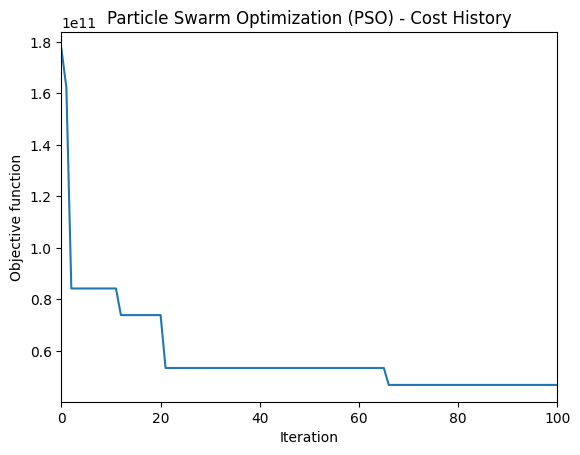

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 336227874271.31305


In [281]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

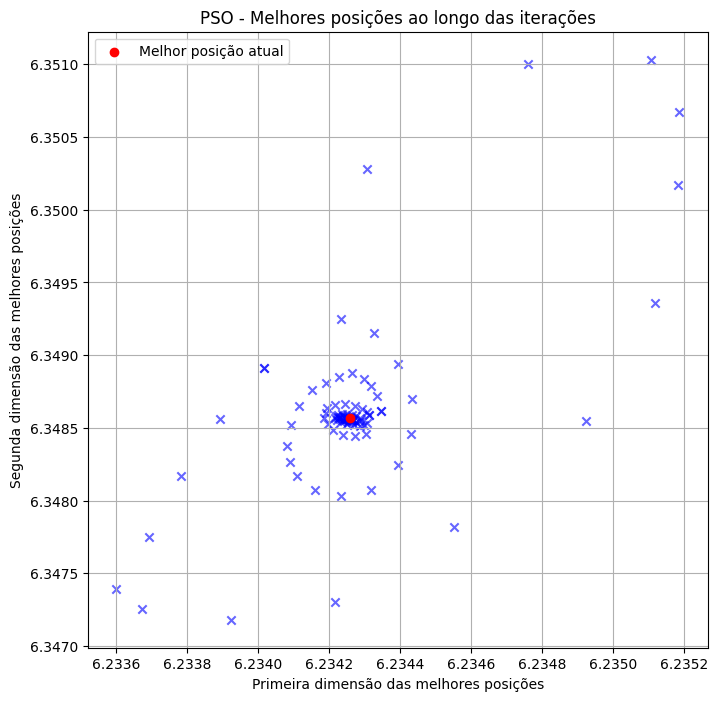

In [282]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()